# Laplacian experiment

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set seed
np.random.seed(1)
torch.manual_seed(1)

## Define distribution

In [2]:
dim = 1

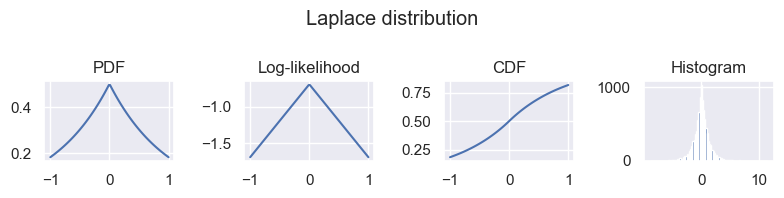

In [3]:
# Sample data points from Laplacian distribution:
# exp(-|x|/b) / (2b)
def sample_laplace(n, b):
    """
    Inputs:
        n: number of points
        b: scale parameter of the Laplacian distribution
    Outputs:
        x: a vector of n points, torch.tensor
    """
    x = torch.distributions.laplace.Laplace(0, b).sample((n,))
    return x


class LaplaceSampler(object):
    def __init__(self, b):
        self.b = b

    def __call__(self, n):
        return sample_laplace(n, self.b)


b = 1.0
dist = torch.distributions.laplace.Laplace(0, b)
x = LaplaceSampler(b)(10000)
# plot pdf, log-likelihood, cdf
plt.rcParams["figure.figsize"] = (8, 2)
x = torch.linspace(-1, 1, 100)
plt.subplot(1, 4, 1)
plt.plot(x, dist.log_prob(x).exp())
plt.title("PDF")
plt.subplot(1, 4, 2)
plt.plot(x, dist.log_prob(x))
plt.title("Log-likelihood")
plt.subplot(1, 4, 3)
plt.plot(x, dist.cdf(x))
plt.title("CDF")
plt.subplot(1, 4, 4)
plt.hist(sample_laplace(10000, b), bins=100)
plt.title("Histogram")
plt.suptitle("Laplace distribution")
plt.tight_layout()

In [9]:
# Add noise to the data
def add_noise(x, sigma=0.1):
    """
    Inputs:
        x: a vector of n points, torch.tensor
        sigma: standard deviation of the noise
    Outputs:
        x: a vector of n points, torch.tensor
    """
    noise = torch.randn_like(x) * sigma
    return x + noise

In [10]:
# parameters for laplace distribution
b = 1
sigma_noise = 1
sampler = LaplaceSampler(b)

Text(0.5, 1.0, 'Example training points')

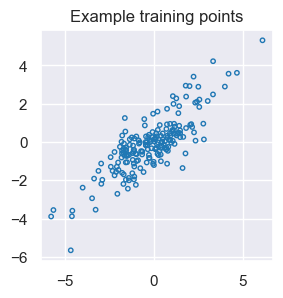

In [11]:
# example training points
target = sampler(200).unsqueeze(1)
input = add_noise(target, sigma_noise)
plt.rcParams["figure.figsize"] = (3, 3)
plt.scatter(input, target, s=10, facecolors="none", edgecolors="tab:blue")
plt.grid("on")
plt.title("Example training points")

### Plot function

In [12]:
# function to plot learned prox, convex function, original function
def plot_all(model):
    xi = np.linspace(-4, 4, 1000)

    y = prox(xi, model)
    c = cvx(xi, model)
    p = prior(xi, model)

    plt.rcParams["figure.figsize"] = (8, 3)

    # learned prox
    plt.subplot(1, 3, 1)
    plt.plot(xi, y, "-", ms=5, label="LPN")
    plt.plot(xi, soft_thr(xi), "--", label="soft thr.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # convex function
    plt.subplot(1, 3, 2)
    plt.plot(xi, c - c.min(), "-", ms=5, label="Cvx func")
    plt.plot(xi, gt_cvx(xi), "--", label="ref.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # original function
    plt.subplot(1, 3, 3)
    plt.plot(xi, p - p.min(), label="LPN")
    plt.plot(xi, np.abs(xi), "--", label=r"$\ell_1$", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Original func")

    plt.tight_layout()

## Define loss

Text(0.5, 1.0, 'exp loss')

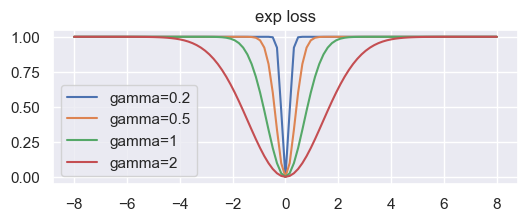

In [13]:
# proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1


# visualize the loss at different sigma
plt.rcParams["figure.figsize"] = (6, 2)
x = torch.linspace(-8, 8, 101)
for gamma_exp_loss in [0.2, 0.5, 1, 2]:
    plt.plot(x, exp_func(x, gamma_exp_loss), label="gamma=" + str(gamma_exp_loss))
plt.legend()
plt.grid("on")
plt.title("exp loss")

## Model parameters

In [14]:
beta = 10  # beta of softplus
hidden = 50  # number of hidden units
layers = 4  # number of layers

# create a model
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
print(
    "Number of parameters in ICNN",
    sum(p.size().numel() for p in lpn_model.parameters()),
)

Number of parameters in ICNN 10502


## Training function

In [15]:
def single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss=None):
    target = sampler(bsize).unsqueeze(1)
    input = add_noise(target, sigma_noise)
    input, target = input.to(device), target.to(device)
    out = lpn_model(input)

    if loss_type == 2:
        loss = (out - target).pow(2).sum() / bsize  # MSE loss
    elif loss_type == 1:
        loss = (out - target).abs().sum() / bsize  # MAE loss
    elif loss_type == 0:
        loss = exp_func(out - target, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    # if not i % 500:
    #     print("iteration", i, "loss", loss.item(), "loss_lstar", loss_lstar.item())

# Train

L2 loss

mse 5.34401273727417
mse 3.6253442764282227
mse 1.900504231452942
mse 0.679203987121582
mse 0.17853793501853943
mse 0.037579093128442764
mse 0.006723033729940653
mse 0.0012291455641388893
mse 0.0003602570795919746
mse 0.00012839083501603454
final mse 4.657652243622579e-05
(1000,) (1000,) (1000,) (1000,)
Values at [-3,-2,-1,0,1,2,3]: tensor([-2.0312e+00, -1.1561e+00, -4.8481e-01,  1.5125e-03,  5.0120e-01,
         1.1525e+00,  2.0010e+00], grad_fn=<SqueezeBackward1>)


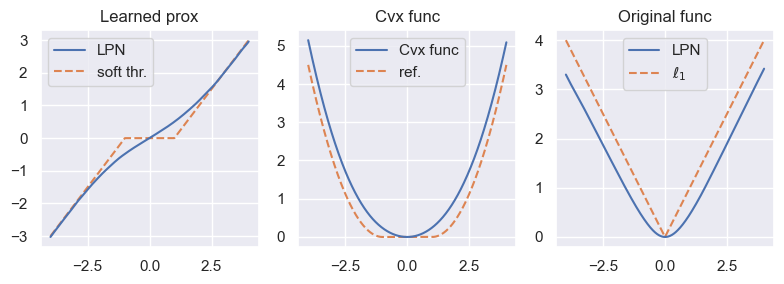

In [17]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
bsize = 2000

for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

L1 loss

mse 5.344016075134277
mse 3.722944736480713
mse 1.705845594406128
mse 0.5020440220832825
mse 0.12072832137346268
mse 0.025000441819429398
mse 0.005087896715849638
mse 0.0010524657554924488
mse 0.0001803386548999697
mse 2.5146147891064174e-05
final mse 2.9953564535389887e-06
(1000,) (1000,) (1000,) (1000,)
Values at [-3,-2,-1,0,1,2,3]: tensor([-2.0271, -1.1098, -0.4301, -0.0023,  0.4283,  1.1093,  2.0135],
       grad_fn=<SqueezeBackward1>)


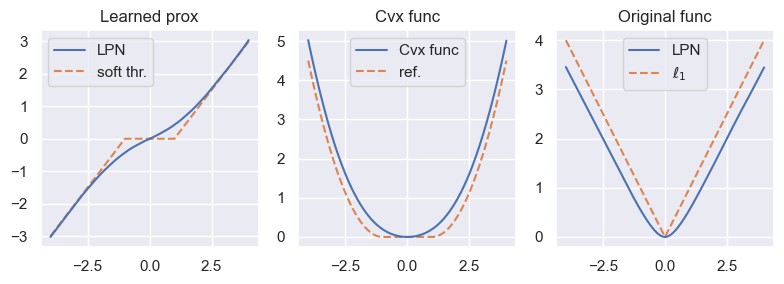

In [18]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
bsize = 2000

for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=1)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=1)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

## Proximal matching loss

gamma=0.5

mse 5.344082832336426
mse 4.132604122161865
mse 1.4418857097625732
mse 0.3782157599925995
mse 0.09043678641319275
mse 0.02476624771952629
mse 0.005645491182804108
mse 0.0011753475992009044
mse 0.00023790802515577525
mse 4.7583525883965194e-05
final mse 9.91037995845545e-06
(1000,) (1000,) (1000,) (1000,)


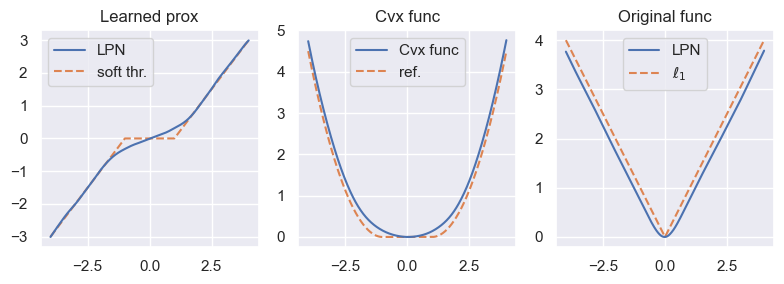

In [19]:
loss_type = 0
gamma_loss = 0.5

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-3

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.4

mse 5.3440165519714355
mse 4.244701385498047
mse 1.352980613708496
mse 0.3897329568862915
mse 0.09817342460155487
mse 0.022818345576524734
mse 0.004421524703502655
mse 0.0008436444331891835
mse 0.00015509584045503289
mse 2.6400814022053964e-05
final mse 4.189309947832953e-06
(1000,) (1000,) (1000,) (1000,)


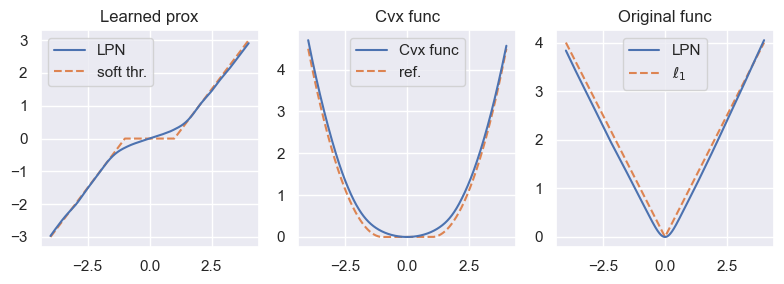

In [20]:
gamma_loss = 0.4
for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.3

mse 5.344050884246826
mse 4.369697570800781
mse 1.1200419664382935
mse 0.31052038073539734
mse 0.08192423731088638
mse 0.020728426054120064
mse 0.005058106500655413
mse 0.001205837237648666
mse 0.00028058019233867526
mse 6.931556708877906e-05
final mse 1.9368397261132486e-05
(1000,) (1000,) (1000,) (1000,)


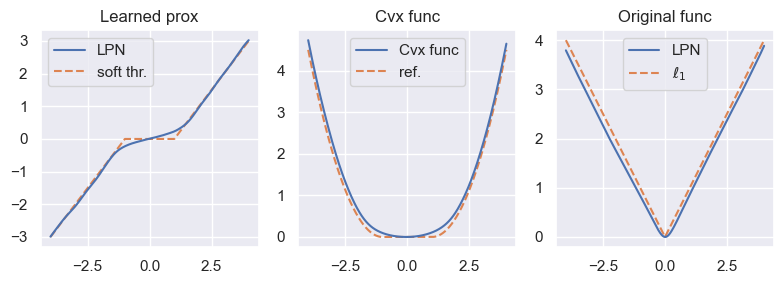

In [21]:
gamma_loss = 0.3
for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.2

mse 5.344015121459961
mse 4.396597862243652
mse 1.0574679374694824
mse 0.3205057978630066
mse 0.07740699499845505
mse 0.017273753881454468
mse 0.003314773552119732
mse 0.0006354665965773165
mse 0.00013790106459055096
mse 3.579625263228081e-05
final mse 1.0375951205787715e-05
(1000,) (1000,) (1000,) (1000,)


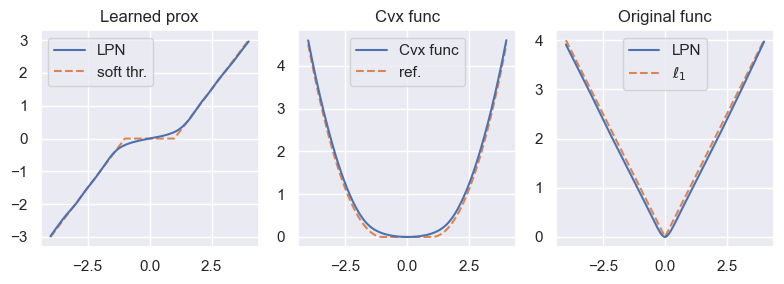

In [22]:
gamma_loss = 0.2
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.1

mse 5.344021320343018
mse 4.331211090087891
mse 0.9436962008476257
mse 0.3200010061264038
mse 0.08560076355934143
mse 0.0216380562633276
mse 0.004422998987138271
mse 0.0008897566585801542
mse 0.00021331061725504696
mse 6.067943468224257e-05
final mse 1.8217975593870506e-05
(1000,) (1000,) (1000,) (1000,)


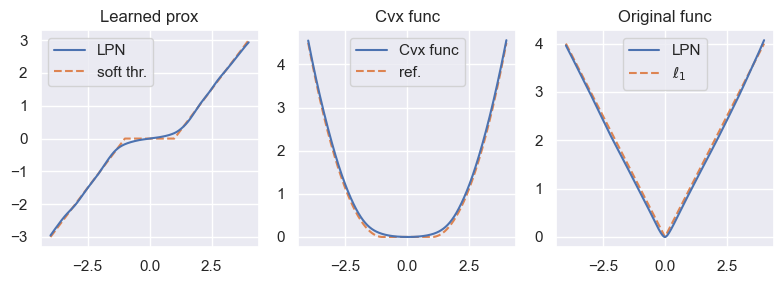

In [23]:
gamma_loss = 0.1
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)